In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix, precision_score


# Loading the data
df = pd.read_csv('initial_cleaned_winner_data.csv')

In [45]:
# Check data entry
print(df.tail(5))  
print(df.columns)  

      raceId  season  raceNumber  Grand Prix  Race Date  Driver Code  \
9155    1096    2022          22         1.0   20221120          854   
9156    1096    2022          22         1.0   20221120          825   
9157    1096    2022          22         1.0   20221120            1   
9158    1096    2022          22         1.0   20221120          849   
9159    1096    2022          22         1.0   20221120            4   

      Team Code  Driver POS Standings  Laps  Team Race Points  ...  \
9155        210                    12    57               0.0  ...   
9156        210                    16    57               0.0  ...   
9157        131                     5    55              10.0  ...   
9158          3                    20    55               0.0  ...   
9159        214                    10    27               6.0  ...   

      Team Champ Points  Team Champ Pos  Team Champ Wins  Driver Champ Points  \
9155               37.0             8.0              0.0         

Features Correlation with the Target Column (Winner)


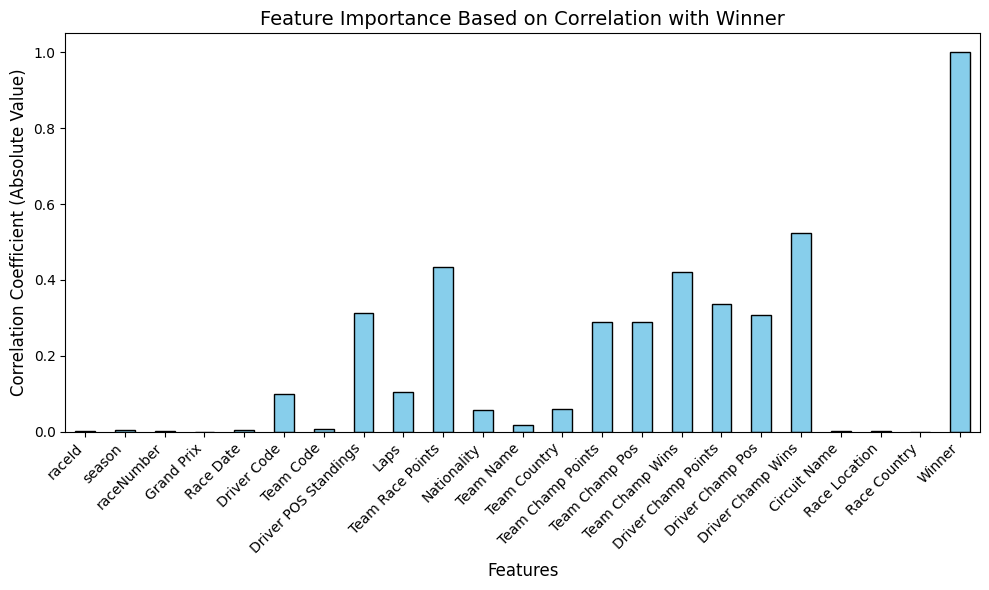

In [46]:
# Calculate correlation matrix for feature selection
correlation_matrix = df.corr()

# Select features with high correlation with "Winner"
print("Features Correlation with the Target Column (Winner)")
correlation_target = abs(correlation_matrix['Winner'])

# Plot correlation with target("Winner")
plt.figure(figsize=(10, 6))
correlation_target.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Feature Importance Based on Correlation with Winner', fontsize=14)
plt.ylabel('Correlation Coefficient (Absolute Value)', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [139]:
# Selecting features with correlation > 0.4 for training the model
print("Final Selected Features")
selected_features = correlation_target[correlation_target > 0.4].index.tolist()
print(selected_features)

Final Selected Features
['Team Race Points', 'Team Champ Wins', 'Driver Champ Wins', 'Winner']


In [140]:
# Spliting data in features and target value
X = df[selected_features].drop(columns=['Winner'])
y = df['Winner']


In [147]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [154]:
preds = model.predict(X_test)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
print(f"Recall (Winner Class): {recall}")
print(f"Accuracy: {accuracy}")


Recall (Winner Class): 0.5
Accuracy: 0.9683406113537117


In [155]:
# Hyperparameter tuning for KNN
param_grid = {
    'n_neighbors': range(2, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_knn = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


In [156]:
# Train the best model and evaluate
best_knn.fit(X_train, y_train)
predictions = best_knn.predict(X_test)

# Calculating Recall and Accuracy
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print(f"Recall (Winner Class): {recall}")
print(f"Accuracy: {accuracy}")

Recall (Winner Class): 0.5365853658536586
Accuracy: 0.9656113537117904


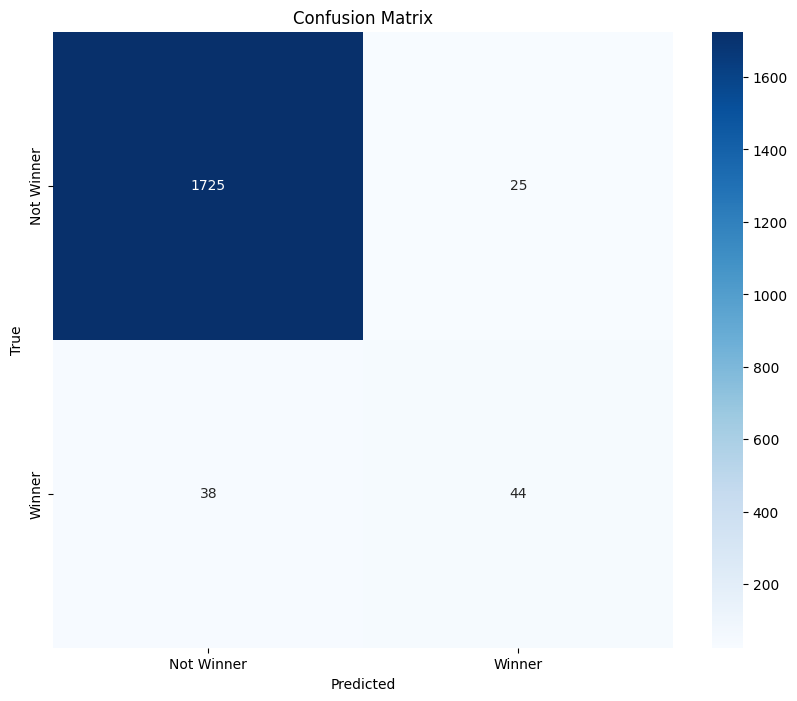

In [157]:
# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Winner', 'Winner'], yticklabels=['Not Winner', 'Winner'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

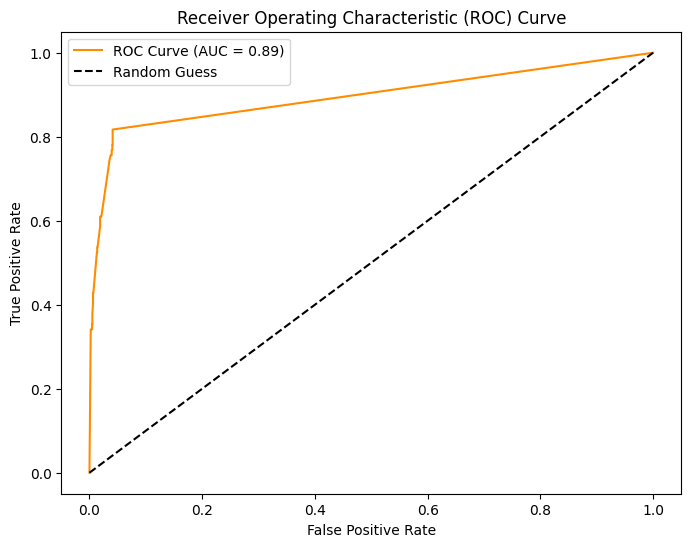

In [161]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = best_knn.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
